In [1]:
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.pipeline import Pipeline, make_pipeline

from aif360.sklearn.preprocessing import ReweighingMeta, Reweighing
from aif360.sklearn.inprocessing import AdversarialDebiasing
from aif360.sklearn.postprocessing import CalibratedEqualizedOdds, PostProcessingMeta

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

from sklego.preprocessing import InformationFilter

from fairness import fairestimator, utils

np.random.seed(42)

# Ignoring bias for classification problems

This notebook is part of a blog series where I investigate bias in AI.

1. [Introducing the IgnoringEstimator](https://github.com/SjoerdCor/fairness/blob/main/blog/1.IntroducingTheIgnoringEstimator.ipynb) introduced measures of fairness and showed how naive approaches do not solve them, and on the other hand shows how easily the IgnoringEstimator is implemented and solves them well
1. [Dealing with more complex biases](https://github.com/SjoerdCor/fairness/blob/main/blog/2.DealingWithMoreComplexBiases.ipynb) showed how common complex biases are: non-linear, correlated with other attributes and for continuous features, and showed how easy it is to mitigate the disparate treatment with the `IgnoringBiasEstimator`. I also showed how little attention there seems to be for this problem in existing approaches.
1. [Ignoring bias for cassification poblems](https://github.com/SjoerdCor/fairness/blob/main/blog/3.IgnoringBiasForClassificationProblems.ipynb) finally shows how to use the Ignoring Estimator for the classic classification problems - since these are more prolific, we can also compare against a wide variety of existing approaches and see the `IgnoringBiasEstimator` does equally well or better both in terms of bias mitigation and accuracy.


In [2]:
PROTECTED_ATTRIBUTE = ['Age']

## Creating the dataset

In [3]:
def generate_employees_age(size=2500):
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'SocialSkills': np.random.rand(size)
                      }
                     )
        )
    return X

def quadratic_bonus(age, effect_size=1):   
    bias = -1 * age.sub(age.mean()).pow(2)
    bias = (bias - bias.mean())/bias.std() # Make  the bias neutral
    return bias * effect_size

def eligibility_to_promotion(e):
    ''' Real numer -> 0/1 based on binomial distribution via sigmoid'''
    prob = scipy.special.expit(e)  # Use logistic function to map real number to probability in range [0, 1]
    return np.random.binomial(1, prob) # Turn into yes/no

def add_promotion(df):
    weights = {'Age': 0,
               'Education': 0.02,
               'SocialSkills': 0.1
              }
    error = np.random.normal(-2, 0.2, size=len(df))
    df = df.assign(PromotionEligibilitySkill = lambda df: df.mul(weights).sum('columns').add(error),
                   PromotionEligibilityTrue = lambda df: (df['PromotionEligibilitySkill']
                                                          .add(quadratic_bonus(df['Age'], 0.4))
                                                         ),
                   PromotionSkill = lambda df: df['PromotionEligibilitySkill'].apply(eligibility_to_promotion),
                   PromotionTrue = lambda df: df['PromotionEligibilityTrue'].apply(eligibility_to_promotion),
                  )
    return df

df_age = generate_employees_age(25000).pipe(add_promotion)

In [4]:
(X_age_train, X_age_test,
 y_age_train, y_age_test,
 y_age_skill_train, y_age_skill_test,
 promotion_prob_skill_train, promotion_prob_skill_test) = sklearn.model_selection.train_test_split(df_age.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                             df_age['PromotionTrue'],
                                                                                             df_age['PromotionSkill'],
                                                                                             df_age['PromotionEligibilitySkill'],
                                                                                                   random_state=42
                                                                                                    )

X_age_train_small = X_age_train.drop(columns=['Age'])
X_age_test_small = X_age_test.drop(columns=['Age'])

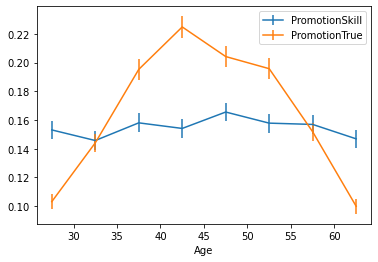

In [5]:
def plot_promotion_prob_by_age(predictions, age, age_group=5, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    age_grouped = age // age_group * age_group + age_group/2
    result = predictions.groupby(age_grouped).agg(['mean', 'sem'])
    ax = (result.plot(y='mean', yerr='sem', ax=ax, label=predictions.name, **kwargs))
    return ax
    
ax = plot_promotion_prob_by_age(df_age['PromotionSkill'], df_age['Age'])
plot_promotion_prob_by_age(df_age['PromotionTrue'], df_age['Age'], ax=ax)
plt.show()

## Calculating the predictions


In [6]:
predictions = {}

In [7]:
def add_predictions_to_results(clf, name, predictions=predictions,
                               X_train=X_age_train, y_train=y_age_train, X_test=X_age_test,
                               protected_attribute=None):
    if protected_attribute: 
        X_train = X_train.set_index(protected_attribute, append=True)
        X_test = X_test.set_index(protected_attribute, append=True)
    clf.fit(X_train, y_train)
    y_pred = utils.predict_series(clf, X=X_test, method='predict_proba')
    if protected_attribute:
        y_pred = y_pred.reset_index(protected_attribute, drop=True)
    predictions[name] = y_pred

In [8]:
rf_kwargs = {'min_samples_leaf': 2, 'random_state': 42}

### Naive
As a baseline, let's first calculate the naive approach of fitting a model with the protected attribute as a feature

In [9]:
rf = RandomForestClassifier(**rf_kwargs)
add_predictions_to_results(rf, 'Naive')

### Information Filter

In [10]:
clf_information_filter = make_pipeline(InformationFilter(PROTECTED_ATTRIBUTE),
                                       RandomForestClassifier(**rf_kwargs),
                                      )
add_predictions_to_results(clf_information_filter, 'InformationFilter')

### aif360 Preprocessing: reweighing

In [11]:
%%time
clf_reweighing = ReweighingMeta(RandomForestClassifier(**rf_kwargs), reweigher=Reweighing(PROTECTED_ATTRIBUTE))
add_predictions_to_results(clf_reweighing, 'Reweighing', protected_attribute=PROTECTED_ATTRIBUTE)

Wall time: 33.7 s


### aif360 Inprocessing: Adversarial Debiasing

In [12]:
%%time
clf_adv_deb = AdversarialDebiasing(prot_attr=PROTECTED_ATTRIBUTE, adversary_loss_weight=None, random_state=42, classifier_num_hidden_units=64)
add_predictions_to_results(clf_adv_deb, 'AdversarialDebiasing', protected_attribute=PROTECTED_ATTRIBUTE)

Wall time: 5min 3s


### aif360 Postprocessing: CalibratedOddsEqualizer

In [13]:
def add_age_index(series, age_series, dummify=None):
    '''
    dummify: tuple of low and high to dummify; None if you do not want to dummify
    ''' 
    
    res = pd.concat([series, age_series], axis='columns')
    if dummify:
        res['Age'] = res['Age'].between(*dummify).astype(int)
    res = res.set_index('Age', append=True).squeeze()
    return res

In [14]:
advantaged_age_group = (32.5, 57.5)
y_train_with_age = add_age_index(y_age_train, X_age_train['Age'], advantaged_age_group)
y_test_with_age = add_age_index(y_age_test, X_age_test['Age'], advantaged_age_group)

In [15]:
clf_postproc = PostProcessingMeta(estimator=RandomForestClassifier(**rf_kwargs),
                                  postprocessor=CalibratedEqualizedOdds(PROTECTED_ATTRIBUTE, random_state=42),
                                  random_state=42)

X_test_grouped_age = X_age_test.assign(Age = lambda df: df['Age'].between(*advantaged_age_group).astype(int))  # CalibratedOddsEqualizer requires exactly two groups
add_predictions_to_results(clf_postproc, 'CalibratedOddsEqualizer', y_train=y_train_with_age, protected_attribute=PROTECTED_ATTRIBUTE, X_test=X_test_grouped_age)

### Ignoring Bias during prediction again solves the problem

In [16]:
ib = fairestimator.IgnoringBiasClassifier(RandomForestClassifier(random_state=42, min_samples_leaf=2),
                                          ignored_cols=[0], # Ignore the zeroeth column at prediction time -> Age
                                          correction_strategy='Logitadditive')

add_predictions_to_results(ib, 'IgnoringBias')

## Measuring fairness

In [17]:
df_predictions = pd.DataFrame(predictions)
df_bias = df_predictions.sub(promotion_prob_skill_test, axis=0)

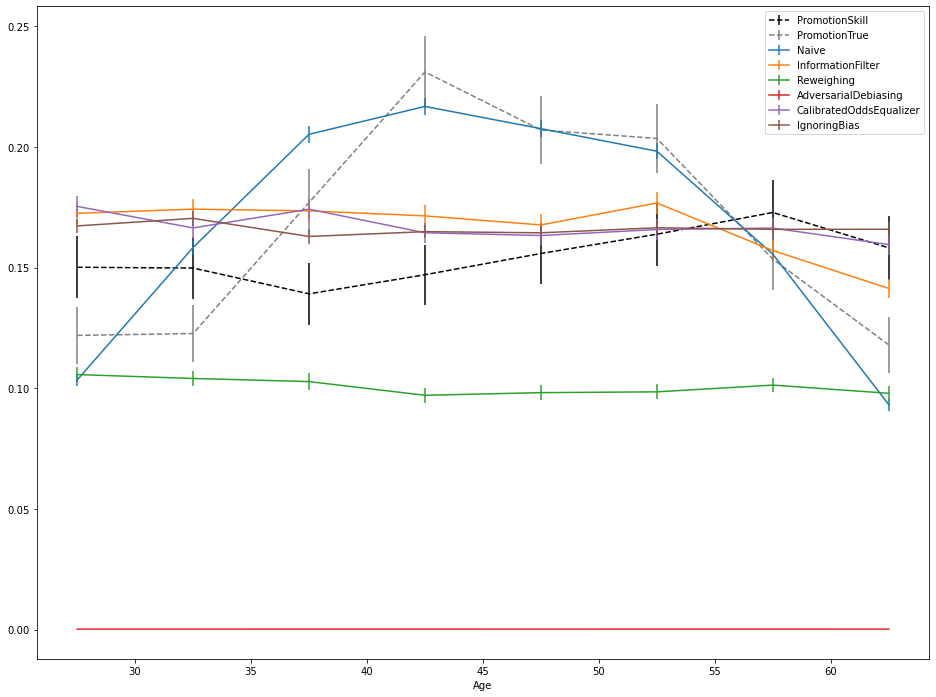

In [18]:
ax = plot_promotion_prob_by_age(y_age_skill_test, X_age_test['Age'], figsize=(16, 12), ls='--', c='k')
plot_promotion_prob_by_age(y_age_test, X_age_test['Age'], ax=ax, ls='--', c='grey')

for col in df_predictions:
    plot_promotion_prob_by_age(df_predictions[col], X_age_test['Age'], ax=ax)

plt.show()

In [19]:
def calculate_disparate_treatment(bias, age, **kwargs):
    dis = mutual_info_regression(bias, age, **kwargs)
    
    return {c: di for c, di in zip(bias.columns, dis)}

In [23]:
def calculate_disparate_treatment_with_unc(bias, age, n_bootstrap=500, **kwargs):
    result = []
    for _ in range(n_bootstrap):
        bootstrap_sample = bias.sample(frac=1, replace=True)
        
        result.append(calculate_disparate_treatment(bootstrap_sample, age.reindex(bootstrap_sample.index), **kwargs))
    return result

In [24]:
%%time
res = calculate_disparate_treatment_with_unc(df_bias, X_age_test['Age'], 500, n_neighbors=100)

Wall time: 8min 55s


In [34]:
dt_unc = (pd.DataFrame(res)
          .quantile([0.025, 0.5, 0.975])
         .transpose().assign(unc = lambda df: df[0.975].sub(df[0.025]).div(2)).transpose()
         )

In [35]:
dt_unc

,Naive,InformationFilter,Reweighing,AdversarialDebiasing,CalibratedOddsEqualizer,IgnoringBias
0.025,0.022918,0.003051,0.002788,0.002995,0.002603,0.001881
0.5,0.030222,0.008328,0.007915,0.007836,0.007338,0.006688
0.975,0.037110,0.013816,0.013023,0.012553,0.013620,0.011927
unc,0.007096,0.005383,0.005117,0.004779,0.005508,0.005023


<AxesSubplot:ylabel='FairnessMethod'>

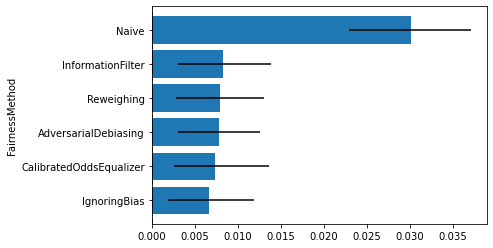

In [52]:
def plot_biases(biases: dict, **kwargs):
    """
    Plot fairness metric with uncertainty for multiple mitigation strategies.

    biases: fairness metrics, dict of dicts structured 
        {"name": {"diff_mean": fairness metric, "diff_sem": uncertainty fairness metric}}
    **kwargs are passed to the DataFrame plot method
    """
    fig, ax = plt.subplots()
    df = pd.DataFrame(biases).transpose().assign(err_lower= lambda df: df[0.5]-df[0.025], err_upper = lambda df: df[0.975]-df[0.5])
    ax.barh(y=range(len(df)), width=df[0.5], xerr=(df['err_lower'], df['err_upper']))
    plt.yticks(range(len(df)), df.index)
    ax.invert_yaxis()
    ax.axvline(0, c='k', ls='--')
#     ax.bar_label(ax.containers[0], label_type='edge', fmt='%.3f')
#     plt.margins(x=0.1)  # Make room for labels

    ax.set_ylabel('FairnessMethod')
    return ax

plot_biases(dt_unc)